In [1]:
# Dependencies and Setup
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps

from sodapy import Socrata
low_memory = False


In [2]:
# State wide Covid-19 vaccines administered by county 

ca_vaccin_data = pd.read_csv("./statewide-covid-19-vaccines-administered-by-county.csv")

ca_vaccin_data_all = ca_vaccin_data.query('county =="All CA Counties"')


# Creating a dataframe with selected columns
ca_vaccin_data = pd.DataFrame(ca_vaccin_data_all, columns=['administered_date','total_doses','pfizer_doses',\
                                                         'moderna_doses','jj_doses','partially_vaccinated',\
                                                         'fully_vaccinated'])

# Creating dataframe for cumulative vaccination 
cumulative_vaccin_data = pd.DataFrame(ca_vaccin_data_all, columns=['administered_date','cumulative_total_doses',\
                                                         'total_partially_vaccinated','cumulative_fully_vaccinated'])


# Converting the string format of date into datetime and created a new column for month
ca_vaccin_data['month'] = pd.DatetimeIndex(ca_vaccin_data['administered_date']).month  #_name()

# ca_vaccin_by_months = ca_vaccin_by_months.reindex(ca_vaccin_data['month'])


ca_vaccin_by_months_sum = ca_vaccin_data.groupby(ca_vaccin_data['month']).sum()
ca_vaccin_by_months_sum

ca_vaccinated = pd.DataFrame(ca_vaccin_data, columns=['month','fully_vaccinated','partially_vaccinated'])
ca_vaccinated



,month,fully_vaccinated,partially_vaccinated
0,12,0,1188
1,12,0,8761
2,12,0,26794
3,12,1,45570
4,12,1,25656
...,...,...,...
226,7,29829,45950
227,7,35760,53091
228,7,21819,33701
229,8,9603,18298


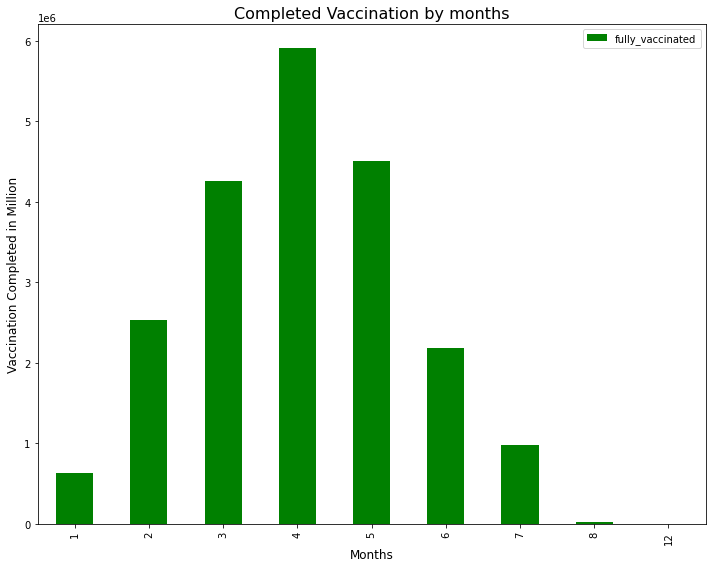

In [3]:
# Generate a bar plot showing the total number of completed vaccination by months

ca_vaccinated = pd.DataFrame(ca_vaccin_data, columns=['month','fully_vaccinated'])

# print(ca_vaccinated.month)

ca_vaccinated_month = ca_vaccinated.groupby(ca_vaccinated['month']).sum()
ca_vaccinated_month


ca_vaccinated_month = ca_vaccinated_month  #.sort_values(by = 'month', ascending = True)

bar_pandas = ca_vaccinated_month.plot.bar(figsize=(10,8), color='g')

plt.xlabel("Months",fontsize = 12)
plt.ylabel("Vaccination Completed in Million",fontsize = 12)
plt.title("Completed Vaccination by months",fontsize = 16)

plt.tight_layout()
plt.show()

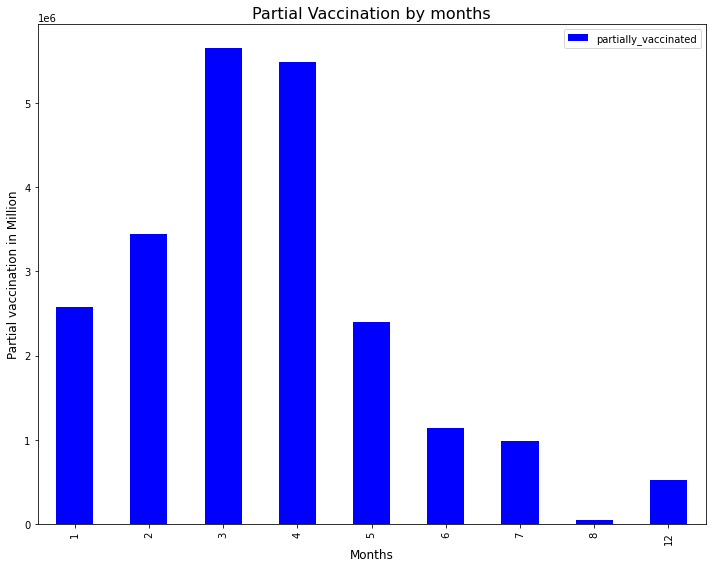

In [5]:
ca_vaccinated_partial = pd.DataFrame(ca_vaccin_data, columns=['month','partially_vaccinated'])

ca_vaccinated_partial_month = ca_vaccinated_partial.groupby(ca_vaccinated_partial['month']).sum()
ca_vaccinated_partial_month



ca_vaccinated_partial_month = ca_vaccinated_partial_month.sort_values(by = 'month', ascending = True)

bar_pandas = ca_vaccinated_partial_month.plot.bar(figsize=(10,8), color='b')

plt.xlabel("Months",fontsize = 12)
plt.ylabel("Partial vaccination in Million",fontsize = 12)
plt.title("Partial Vaccination by months",fontsize = 16)


plt.tight_layout()
plt.show()


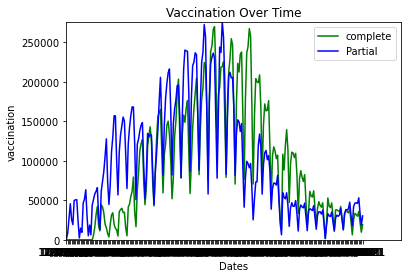

In [7]:
import matplotlib.pyplot as plt
import numpy as np

ca_vaccinated = pd.DataFrame(ca_vaccin_data, columns=['administered_date','month','fully_vaccinated', 'partially_vaccinated'])

dates = ca_vaccinated['administered_date']
complete = ca_vaccinated['fully_vaccinated']
partial = ca_vaccinated['partially_vaccinated']

# Plot the charts and apply some styling

complete, = plt.plot(dates, complete, color="g", label="complete")
partial, = plt.plot(dates, partial, color="b", label="Partial")

# Add labels to X and Y axes :: Add title
plt.title("Vaccination Over Time")
plt.xlabel("Dates")
plt.ylabel("vaccination")

# Set the limits for the X and Y axes
plt.xlim(0,260)
plt.ylim(0,275000)

# Create a legend for the chart
plt.legend(handles=[complete, partial], loc="best")

# Add in a grid for the chart
# plt.grid()
plt.show()

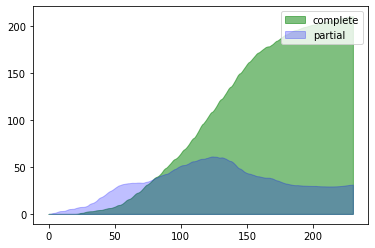

In [10]:
# cumulative_vaccin_data

dates = cumulative_vaccin_data['administered_date']
complete = cumulative_vaccin_data['cumulative_fully_vaccinated']/100000
partial = cumulative_vaccin_data['total_partially_vaccinated']/100000

# Plot the charts and apply some styling

# plt.fill_between(dates, complete, color="g", alpha =0.75, label="complete")
# plt.fill_between(dates, partial, color="b",  alpha =0.5, label="Partial")

# # Add labels to X and Y axes :: Add title
# plt.title("Vaccination Over Time ")
# plt.xlabel("Dates ")
# plt.ylabel("vaccination (x 100,000)")

# # Set the limits for the X and Y axes
# # plt.xlim(0,300)
# # plt.ylim(0,250)

# # Create a legend for the chart
# plt.legend(loc="best")

# # Add in a grid for the chart
# # plt.grid()
# plt.show()

# set ticks manually by weeks

plt.fill_between(np.arange(231), complete, color="green",
                 alpha=0.5, label='complete')
plt.fill_between(np.arange(231), partial, color="blue",
                 alpha=0.25, label='partial')

plt.legend()
plt.show()